In [169]:
import gsd.hoomd
import numpy as np
import gsd.pygsd
import hoomd
import matplotlib
import math
import itertools
import os
import fresnel
import IPython
import packaging.version

In [170]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(position, orientation, L):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=len(position))
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = position[:]
    geometry.orientation[:] = orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    scene.background_alpha = 1
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())


In [171]:
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [172]:
f = gsd.hoomd.open(name='file.gsd', mode='w')

In [173]:
def create_frame(i):

    frame = gsd.hoomd.Frame()

    frame.configuration.step = i

    return frame


f = gsd.hoomd.open(name='example.gsd', mode='w')

f.extend( (create_frame(i) for i in range(10)) )

f.append( create_frame(10) )

In [174]:
integrator = hoomd.md.Integrator(dt=0.005)

In [175]:
integrator.forces[:]

[]

In [176]:
def potential_gradient(positions, bonds, l0, b):
    repulsion_gradient = -4 * np.sum(np.sign(positions[:, np.newaxis] - positions) *
                                     np.exp(-4 * np.abs(positions[:, np.newaxis] - positions) / l0) / l0, axis=1, dtype=np.float128)

    bonding_gradient = 4 * b * np.sum(np.sign(positions[:, np.newaxis] - positions[bonds[:, 0]]) *
                                          np.exp(-4 * b * np.abs(positions[:, np.newaxis] - positions[bonds[:, 0]]) / l0) / l0, axis=1, dtype=np.float128)

    #bonding_gradient = 0
    return repulsion_gradient - bonding_gradient

In [177]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

In [178]:
exp_potential = hoomd.md.pair.Table(nlist = cell)

In [179]:
integrator.forces.append(exp_potential)

In [180]:
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)

In [181]:
integrator.methods.append(nvt)

In [182]:
frame = gsd.hoomd.Frame()
frame.particles.N = 10
frame.particles.types = ['A','M','U']
frame.particles.typeid = np.random.randint(0,len(frame.particles.types),frame.particles.N)
frame.particles.position = np.random.randint(0, high=frame.particles.N, size=(frame.particles.N,3), dtype=int)
frame.configuration.box = [100, 100, 100, 0, 0, 0]

In [183]:
os.remove('test.gsd')
with gsd.hoomd.open(name = 'test.gsd',mode = 'x') as f:
    f.append(frame)

In [184]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device = cpu, seed = 1)
simulation.create_state_from_gsd(filename = 'test.gsd')

In [185]:
simulation.operations.integrator = integrator

In [186]:
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [187]:
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

In [188]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

In [190]:
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(1)

In [191]:
thermodynamic_properties.degrees_of_freedom

0.0

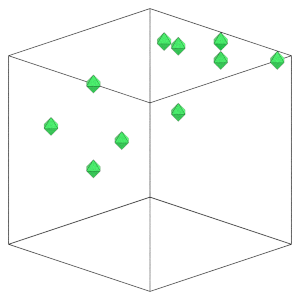

In [192]:
orientation = [(1, 0, 0, 0)] * frame.particles.N
render(frame.particles.position,orientation,10)

In [193]:
hoomd.write.GSD.write(state=simulation.state, filename='random.gsd', mode='xb')